In [27]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import time
from sklearn.preprocessing import LabelEncoder

In [23]:
import warnings; warnings.simplefilter('ignore')

In [15]:
df = pd.read_csv("../../Data/income_evaluation.csv")
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.columns = list(map(lambda x: x.strip(), df.columns))

In [16]:
price_range = df[['income']].to_numpy()
price_range[price_range=="<=50K"] = 0
price_range[price_range==">50K"] = 1
df['income'] = pd.DataFrame(price_range, columns=['income'])
y_new = pd.DataFrame(price_range, columns=['income'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [17]:
# Do a one-hot encoding of string features - otherwise the predict method will fail
for i in df.columns:
    if i in ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
        df[i] = LabelEncoder().fit_transform(df[i])


In [20]:
X = df.drop(columns=['income', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss'])
y = y_new
y=y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
df[['income']].value_counts()

income
0         24720
1          7841
dtype: int64

In [21]:
# preventing information about the distribution of the test set leaking into your model
standard_scaler = MinMaxScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)
y_train_scaled = standard_scaler.fit_transform(y_train).astype('int')
y_test_scaled = standard_scaler.fit_transform(y_test).astype('int')

In [24]:
clf = KNeighborsClassifier(n_neighbors=1)
start_time = time.time()
clf.fit(x_train_scaled, y_train_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test_scaled)
print(f"KNN Normal Model: Predict Time: {time.time() - start_time}")
print(f"Acuracy Score: {accuracy_score(y_test_scaled, y_pred)}")
print(classification_report(y_test_scaled, y_pred))

KNN Normal Model: Fit Time: 0.11227822303771973
KNN Normal Model: Predict Time: 0.3855161666870117
Acuracy Score: 0.7775218793182865
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4945
           1       0.54      0.55      0.54      1568

    accuracy                           0.78      6513
   macro avg       0.70      0.70      0.70      6513
weighted avg       0.78      0.78      0.78      6513



In [34]:
d = df.shape[1]
depth_range = np.arange(1, 40, 1)
param = "n_neighbors"
classifier = "KNN"
train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name=param, param_range=depth_range, cv=5, n_jobs=-1)

ValueError: x and y must have same first dimension, but have shapes (39,) and (9,)

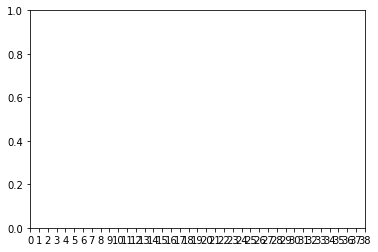

In [74]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = np.arange(0, len(depth_range), 1)
plt.figure()
plt.xticks(np.arange(0, len(depth_range)))
plt.plot(depth_range_list, mean_train_scores, 'o-', label='Training score')
plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

In [60]:
### PIPELINES ###
# Data scaled in pipeline already
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
pipeline.fit(x_train_scaled, y_train_scaled)
print(f"MLP Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline = pipeline.predict(x_test_scaled)
print(f"MLP Pipeline Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline)}")
print(classification_report(y_test_scaled, y_pred_pipeline))

MLP Pipeline Model: Fit Time: 4.000831127166748
MLP Pipeline Model: Predict Time: 0.49013733863830566
Score of Model Tree are (Mean Accuracy of test and train data): 0.8057730692461231
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4945
           1       0.61      0.54      0.57      1568

    accuracy                           0.81      6513
   macro avg       0.73      0.71      0.72      6513
weighted avg       0.80      0.81      0.80      6513



In [61]:
### TUNING ####
d = x_train.shape[1]
param = {'knn__n_neighbors': np.arange(1, 50, 1), 
         'knn__weights':['uniform','distance'],
         'knn__metric':['manhattan','euclidean','chebyshev']
        }
clf_cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True, verbose=1)
start_time = time.time()
clf_cv = clf_cv.fit(x_train_scaled, np.ravel(y_train_scaled))
print(f"MLP CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test_scaled)
print(f"MLP CV Model: Predict Time: {time.time() - start_time}")

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:  1.7min finished


MLP CV Model: Fit Time: 99.23996257781982
MLP CV Model: Predict Time: 1.127812385559082


AttributeError: 'KNeighborsClassifier' object has no attribute 'best_params_'

In [62]:
print(f"Best Params: {clf_cv.best_params_}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline_cv)}")
print(classification_report(np.ravel(y_test_scaled), y_pred_pipeline_cv))

Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 47, 'knn__weights': 'uniform'}
Score of Model Tree are (Mean Accuracy of test and train data): 0.8248119146322739
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      4945
           1       0.67      0.54      0.60      1568

    accuracy                           0.82      6513
   macro avg       0.77      0.73      0.74      6513
weighted avg       0.82      0.82      0.82      6513



In [63]:
train_sizes = np.arange(0.1, 1.0, 0.1)
clf_new = KNeighborsClassifier(metric="manhattan", n_neighbors=47, weights='uniform')
_, train_scores, test_scores = learning_curve(clf_new, x_train, np.ravel(y_train), train_sizes=train_sizes, cv=5)

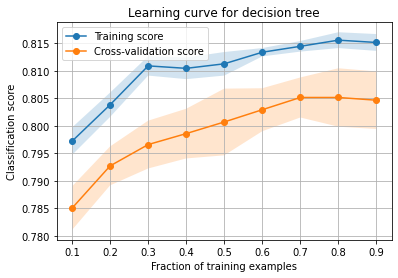

In [64]:
plt.figure()
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

In [65]:
lw = 2
neighbors = np.arange(30, 60, 1)
clf_score_list = []
fit_time_list = []
predict_time_list = []
main_start_time = time.time()
for i in neighbors:
    clf = KNeighborsClassifier(n_neighbors=i, metric='euclidean', weights='distance')
    start_time = time.time()
    clf.fit(x_train_scaled, y_train_scaled)
    clf_score_list.append(clf.score(x_test_scaled, y_test_scaled))
    
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
    
    start_time = time.time()
    y_pred = clf.predict(x_test_scaled)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
    
print(f"Entire cell took {time.time() - main_start_time}")

Entire cell took 46.30338931083679


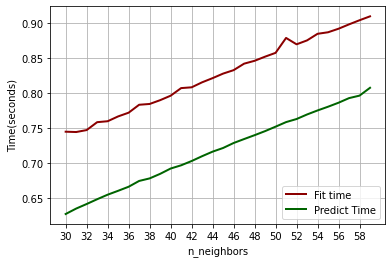

In [68]:
def normalize_data_points(points):
    return points
    return [float(i)/sum(points) for i in points]

lw = 2
param_list = np.arange(30, 60, 1)
# param_list = np.arange(0, len([(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]))
plt.plot(param_list, normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(param_list, normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)

plt.xlabel('n_neighbors')
plt.ylabel("Time(seconds)")
plt.xticks(np.arange(30, 60, 2.0))
# plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')

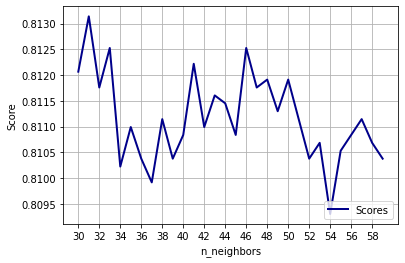

In [72]:
lw = 2
param_list = np.arange(30, 60, 1)
plt.plot(param_list, clf_score_list, label="Scores", color="darkblue", lw=lw)
plt.xlabel('n_neighbors')
plt.ylabel("Score")
plt.xticks(np.arange(30, 60, 2.0))
plt.grid()
plt.legend(loc='lower right')